# Capstone Two - Modeling

On this capstone, we would be trying different models to try to predict the weekly sales at Walmart. 
The data frame we would be using has categorical features and some numeric features such as unemployment, cpi, etc was standarized. 
Some of the models we saw and may implement are:
1. K-Nearest Neighbors
2. Linear Regression
3. Decision Trees
4. Gradient Boosting

Depending on the results and what we are looking for, we would be selecting a model. 

The evaluation of the model is going to be based on the score, accuracy, and all the methods we have seen so far.

In [1]:
#Import Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

## Load the data

In [2]:
#Use pd.read_csv to read the data
df = pd.read_csv('walmart_sales.csv', index_col = 0)

In [3]:
#See how the data frame looks like
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Close,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,53.450001,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,53.450001,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,53.450001,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,53.450001,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,53.450001,A,151315


# Data Wrangling

Firstly, we are going to count the values per store and department in order to reduce the dimensionality of our data set and make more accurate predictions.

In [4]:
pd.set_option('max_rows', None)
pd.DataFrame(df['Store'].value_counts(ascending = True))

,Store
36,6048
33,6307
43,6563
42,6757
30,6951
44,6971
37,7000
38,7157
9,8620
5,8745


In [5]:
pd.set_option('max_rows', None)
pd.DataFrame(df['Dept'].value_counts(ascending = True))

,Dept
43,12
39,16
65,139
77,150
78,227
47,630
99,839
51,1340
50,1518
48,1693


Departments to be deleted

Departments 43, 39, 65, 77, 78, 47, 99, 51, 50, 48, 45

In [6]:
#Use of loc to remove the departments mentioned above
df =df.loc[~df['Dept'].isin([43, 39, 65, 77, 78, 47,99, 51, 50, 48, 45])]

#### Remove Outliers

In [7]:
#Outliers
std = df['Weekly_Sales'].std()
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

In [8]:
df = df.loc[df['Weekly_Sales'] >=  Q1 - 1.5*IQR]
df = df.loc[df['Weekly_Sales'] <= Q3 + 1.5*IQR]

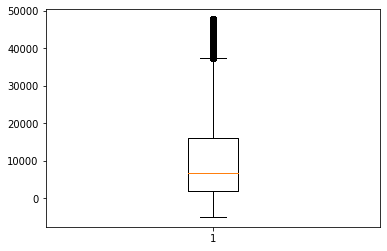

In [9]:
plt.boxplot(df['Weekly_Sales'])
plt.show()

### Feature Selection

We are making correlation matrix with the numerical features to see which ones we can remove.

- Low correlation (approximately 0) we may take off that feature.
- Features highly correlated between them may be removed as well.

In [10]:
#Create a data frame with just the numeric features
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Close', 'Size']
df_numeric = df[numeric_cols]

In [11]:
#Create the correlation matrix
corr_matrix = df_numeric.corr()

In [12]:
#See the complete correlation matrix
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
corr_matrix

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Close,Size
Weekly_Sales,1.000000,-0.001135,0.005084,-0.040834,-0.011384,-0.005120,0.229829
Temperature,-0.001135,1.000000,0.142896,0.176903,0.101041,0.098582,-0.060102
Fuel_Price,0.005084,0.142896,1.000000,-0.170773,-0.028173,0.468994,0.006035
CPI,-0.040834,0.176903,-0.170773,1.000000,-0.315650,0.062554,-0.008079
Unemployment,-0.011384,0.101041,-0.028173,-0.315650,1.000000,-0.217101,-0.062005
Close,-0.005120,0.098582,0.468994,0.062554,-0.217101,1.000000,-0.005236
Size,0.229829,-0.060102,0.006035,-0.008079,-0.062005,-0.005236,1.000000


From the correlation matrix, we select the size of the store since it had an acceptable value of 0.22.The other ones were extremely too low.

# Creation of dummy variables

In [13]:
#Specify the dummies columns in a data frame
dummies_cols = ['Dept', 'Store', 'Type', 'IsHoliday']
df_dummies = df[dummies_cols]

In [14]:
#Use of pd.get_dummies to create the categorical features
df_dummies = pd.get_dummies(df_dummies, columns = ['Dept', 'Store', 'Type', 'IsHoliday'])

In [15]:
#Convert date to date time
df['Date'] = pd.to_datetime(df['Date'])

In [16]:
#Create a data frame with dates as categorical variable
df_date = pd.DataFrame()

df_date['Year'] = pd.Series(df['Date'])
df_date['Year'] = pd.DatetimeIndex(df_date['Year']).year

df_date['Month'] = pd.Series(df['Date'])
df_date['Month'] = pd.DatetimeIndex(df_date['Month']).month

df_date['Day'] = pd.Series(df['Date'])
df_date['Day'] = pd.DatetimeIndex(df_date['Day']).day

# Concat the dummies with the original data frame

In [17]:
#Drop the original columns for the categorical features since they are no longer necessary
df_categorical = df.drop(columns = {'Dept', 'Store', 'Type', 'Date', 'IsHoliday'}, axis = 1)

In [18]:
#Concat the data frames
df_categorical = pd.concat([df_date, df_categorical], axis = 1)
df_categorical = pd.concat([df_categorical, df_dummies], axis = 1)

In [19]:
#See how the final data frame looks like
df_categorical.head()

,Year,Month,Day,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Close,Size,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Dept_7,Dept_8,Dept_9,Dept_10,Dept_11,Dept_12,Dept_13,Dept_14,Dept_16,Dept_17,Dept_18,Dept_19,Dept_20,Dept_21,Dept_22,Dept_23,Dept_24,Dept_25,Dept_26,Dept_27,Dept_28,Dept_29,Dept_30,Dept_31,Dept_32,Dept_33,Dept_34,Dept_35,Dept_36,Dept_37,Dept_38,Dept_40,Dept_41,Dept_42,Dept_44,Dept_46,Dept_49,Dept_52,Dept_54,Dept_55,Dept_56,Dept_58,Dept_59,Dept_60,Dept_67,Dept_71,Dept_72,Dept_74,Dept_79,Dept_80,Dept_81,Dept_82,Dept_83,Dept_85,Dept_87,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
0,2010,2,5,24924.50,42.31,2.572,211.096358,8.106,53.450001,151315,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2010,2,5,13740.12,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,2010,2,5,39954.04,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,2010,2,5,32229.38,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,2010,2,5,5749.03,42.31,2.572,211.096358,8.106,53.450001,151315,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


# Feature Selection Categorical Variables

We will be creating a correlation matrix same as we did with the numerical features and the selection process would be the same.

In [20]:
#Create a correlation matrix with the categorical features
df_sales = df['Weekly_Sales']
df_corr2 = df_categorical.iloc[:, 11:]
df_corr2 = pd.concat([df_sales, df_corr2], axis = 1)

In [21]:
corr_matrix2 = df_corr2.corr()
corr_matrix2

,Weekly_Sales,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Dept_7,Dept_8,Dept_9,Dept_10,Dept_11,Dept_12,Dept_13,Dept_14,Dept_16,Dept_17,Dept_18,Dept_19,Dept_20,Dept_21,Dept_22,Dept_23,Dept_24,Dept_25,Dept_26,Dept_27,Dept_28,Dept_29,Dept_30,Dept_31,Dept_32,Dept_33,Dept_34,Dept_35,Dept_36,Dept_37,Dept_38,Dept_40,Dept_41,Dept_42,Dept_44,Dept_46,Dept_49,Dept_52,Dept_54,Dept_55,Dept_56,Dept_58,Dept_59,Dept_60,Dept_67,Dept_71,Dept_72,Dept_74,Dept_79,Dept_80,Dept_81,Dept_82,Dept_83,Dept_85,Dept_87,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
Weekly_Sales,1.000000,0.133158,-0.006916,0.138860,0.072274,-0.068534,0.077685,0.149747,0.067914,0.074870,0.037969,-0.075999,0.156146,0.038136,0.009705,-0.007799,-0.055923,-0.083951,-0.058757,-0.067581,-0.000928,0.109993,-0.047478,-0.021477,-0.035112,-0.099247,-0.114354,-0.054283,-0.069676,-0.094697,-0.046338,-0.046297,0.047292,-0.082346,-0.091640,-0.055688,0.169664,0.159161,-0.093265,-0.064341,-0.065424,0.091155,-0.025303,-0.100833,-0.105638,-0.008811,-0.077770,-0.067242,-0.114153,-0.113916,-0.039646,-0.053021,0.124295,0.032602,0.106961,0.015171,0.053067,0.044686,-0.082038,-0.095449,0.020936,0.084958,0.080956,0.118814,0.079862,0.081573,0.149174,0.042631,0.039439,-0.043877,0.034021,0.053571,-0.082057,0.049756,-0.087008,0.060480,-0.038337,0.000637,-0.043005,0.047446,0.046091,0.017564,0.053737,0.043153,-0.036164,-0.048922,-0.003276,0.012525,0.036326,0.057552,-0.002934,0.002774,0.059535,0.030902,-0.012853,-0.006343,0.053989,0.033795,-0.040189,-0.049242,0.000694,-0.000553,-0.058740,0.004202,0.015705,-0.036817,-0.042958,-0.052240,0.027531,0.002249,0.019310,-0.036467,-0.036667,-0.061586,-0.011932,0.152151,-0.079320,-0.120031,-0.006961,0.006961
Dept_2,0.133158,1.000000,-0.012983,-0.012601,-0.012654,-0.012704,-0.012600,-0.012256,-0.012617,-0.013001,-0.013123,-0.013157,-0.012088,-0.013110,-0.012824,-0.013156,-0.011408,-0.010515,-0.012761,-0.013183,-0.012221,-0.012075,-0.012064,-0.013097,-0.012440,-0.012307,-0.012856,-0.011956,-0.011936,-0.012797,-0.012669,-0.012048,-0.011937,-0.011943,-0.011940,-0.008300,-0.007529,-0.009916,-0.012049,-0.013150,-0.012141,-0.013005,-0.010985,-0.013008,-0.011313,-0.012222,-0.012567,-0.010859,-0.012837,-0.012479,-0.013183,-0.011956,-0.009466,-0.013144,-0.012846,-0.012601,-0.013168,-0.013120,-0.012623,-0.012783,-0.013015,-0.009852,-0.010971,-0.007956,-0.011378,-0.010279,-0.007716,-0.011409,-0.013018,-0.012540,0.004306,-0.014912,0.009796,-0.014535,0.009839,-0.006528,0.008385,0.008386,0.010275,-0.014656,-0.015167,-0.015660,-0.014816,-0.014472,0.008269,0.009141,0.007441,-0.015136,-0.009089,-0.014483,-0.002600,-0.013543,-0.015411,0.008124,0.007970,0.009428,-0.015114,-0.015653,0.008661,0.015000,-0.015316,-0.009806,0.016136,0.008382,0.002181,0.017471,0.015203,0.013840,-0.015022,0.008666,-0.002252,0.016092,0.017478,0.014157,0.008722,-0.028997,0.004835,0.039190,-0.001140,0.001140
Dept_3,-0.006916,-0.012983,1.000000,-0.016290,-0.016360,-0.016424,-0.016289,-0.015845,-0.016312,-0.016807,-0.016965,-0.017010,-0.015627,-0.016949,-0.016579,-0.017009,-0.014748,-0.013594,-0.016497,-0.017043,-0.015799,-0.015611,-0.015597,-0.016932,-0.016082,-0.015910,-0.016620,-0.015456,-0.015430,-0.016544,-0.016378,-0.015576,-0.015432,-0.015440,-0.015437,-0.010730,-0.009734,-0.012819,-0.015577,-0.017000,-0.015696,-0.016813,-0.014202,-0.016817,-0.014626,-0.015801,-0.016247,-0.014038,-0.016596,-0.016134,-0.017043,-0.015456,-0.012238,-0.016993,-0.016607,-0.016290,-0.017024,-0.016961,-0.016319,-0.016526,-0.016826,-0.012737,-0.014184,-0.010285,-0.014710,-0.013

We are selecting Department: 2, 4, 8, 13, 23, 28, 38, 40, 52, 54, 59, 60, 72, 79, 92, 95; all stores and Type of store

# Variance for feature selection

We will run a variance test to remove the features with lowest variance and double check the process selection did with the correlation test.

In [22]:
from sklearn.feature_selection import VarianceThreshold

In [23]:
#Establish the array with the values
X = df_numeric.values

In [24]:
#Run the variance test
sel = VarianceThreshold(threshold= 0.5)
sel = sel.fit_transform(X)

In [25]:
#See the final data frame
pd.DataFrame(sel, columns = ['Weekly_Sales', 'Temperature', 'CPI', 'Unemployment', 'Close', 'Size'])

,Weekly_Sales,Temperature,CPI,Unemployment,Close,Size
0,24924.50,42.31,211.096358,8.106,53.450001,151315.0
1,13740.12,42.31,211.096358,8.106,53.450001,151315.0
2,39954.04,42.31,211.096358,8.106,53.450001,151315.0
3,32229.38,42.31,211.096358,8.106,53.450001,151315.0
4,5749.03,42.31,211.096358,8.106,53.450001,151315.0
...,...,...,...,...,...,...
367697,16330.84,58.85,192.308899,8.667,75.110001,118221.0
367698,2487.80,58.85,192.308899,8.667,75.110001,118221.0
367699,5203.31,58.85,192.308899,8.667,75.110001,118221.0
367700,6817.48,58.85,192.308899,8.667,75.110001,118221.0


By doing a variance test, we are removing the Fuel Price.

# Train and test split

In [26]:
#Define the final data frame
df_mod = df_categorical[['Year', 'Month', 'Day','Weekly_Sales', 'Size','Dept_2','Dept_4', 'Dept_8', 'Dept_13', 
                         'Dept_23', 'Dept_28', 'Dept_38', 'Dept_40', 'Dept_52', 'Dept_54', 'Dept_59', 'Dept_60', 
                         'Dept_72', 'Dept_79', 'Dept_92' , 'Dept_95', 'Type_A', 'Type_B', 'Type_C']]

In [76]:
df_mod.head()

,Year,Month,Day,Weekly_Sales,Size,Dept_2,Dept_4,Dept_8,Dept_13,Dept_23,Dept_28,Dept_38,Dept_40,Dept_52,Dept_54,Dept_59,Dept_60,Dept_72,Dept_79,Dept_92,Dept_95,Type_A,Type_B,Type_C
0,2010,2,5,24924.50,151315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2010,2,5,13740.12,151315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2010,2,5,39954.04,151315,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2010,2,5,32229.38,151315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,2010,2,5,5749.03,151315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [27]:
#Define the arrays
X = df_mod.drop(columns = {'Weekly_Sales', 'Year', 'Month', 'Day'}, axis = 1).values
y = df_mod['Weekly_Sales'].values

In [28]:
#Divide into train and test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [29]:
#Use Standard Scaler to run the test with and without a scaler
X2 = df_mod['Size'].values.reshape(-1, 1)
y2 = df_mod['Weekly_Sales'].values

In [30]:
from sklearn.preprocessing import StandardScaler
# Making a Scaler object
scaler = StandardScaler()
# Fitting data to the scaler object
scaler.fit(X2)
#Transform the data
scaler_transformed = scaler.transform(X2)

In [31]:
#Do some data wrangling to have the standarized data with the dummies variables that were not standarized
df_date = pd.DataFrame()
df_date['Year'] = df_mod['Year']
df_date['Month'] = df_mod['Month']
df_date['Day'] = df_mod['Day']
df_sales = pd.DataFrame()
df_sales['Weekly_Sales'] = df_mod['Weekly_Sales']
df_scaled = pd.DataFrame(data = scaler_transformed, columns = ['Size'])
df_dummies = df_mod.iloc[:, 5:]

In [32]:
#See the second data frame where we are going to run the test with the standarized values
df_mod2 = pd.concat([df_date, df_sales], axis = 1)
df_mod2 = pd.concat([df_mod2, df_scaled], axis = 1)
df_mod2 = pd.concat([df_mod2, df_dummies], axis = 1)
df_mod2.dropna(inplace = True)

In [33]:
df_mod2.head()

,Year,Month,Day,Weekly_Sales,Size,Dept_2,Dept_4,Dept_8,Dept_13,Dept_23,Dept_28,Dept_38,Dept_40,Dept_52,Dept_54,Dept_59,Dept_60,Dept_72,Dept_79,Dept_92,Dept_95,Type_A,Type_B,Type_C
0,2010.0,2.0,5.0,24924.50,0.296386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2010.0,2.0,5.0,13740.12,0.296386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2010.0,2.0,5.0,39954.04,0.296386,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2010.0,2.0,5.0,32229.38,0.296386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,2010.0,2.0,5.0,5749.03,0.296386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [34]:
#Define the other 2 arrays to make comparison with the tests. 
X2 = df_mod2.drop(columns = {'Weekly_Sales', 'Year', 'Month', 'Day'}, axis = 1).values
y2 = df_mod2['Weekly_Sales'].values

In [35]:
#Split the data for the second array
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.25, random_state = 123)

# Modeling

### Linear Regression

In [36]:
#Define function to make cross validation
def grid_search(model, param_grid, cv = 3):
    model = model()
    model_cv = GridSearchCV(model, param_grid, cv = 3)
    model_cv.fit(X_train, y_train)
    print('Based on the Cross Validation, the best parameters were:',
          model_cv.best_params_, 'with a score of:', model_cv.best_score_)

#### Standard Linear Regression

In [37]:
#Import library and run the test
from sklearn.linear_model import LinearRegression

# Run the function, fit and predict
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred1 = reg.predict(X_test)

In [38]:
#Print the scores of the test and train set
print('The R-Square of the train data set is:', reg.score(X_train, y_train))
print('The R-Square of the test data set is:', reg.score(X_test, y_test))

The R-Square of the train data set is: 0.3685049379638988
The R-Square of the test data set is: 0.3699338460585318


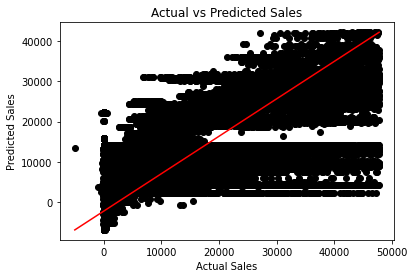

In [39]:
#Plot the results
plt.scatter(y_test, y_pred1, color = 'black')
x0 = min(y_test)
x1 = max(y_test)
y0 = min(y_pred1)
y1 = max(y_pred1)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

As we can see, the R-Square is not that good, we would be trying different linear functions to see our best model


In [40]:
#Same pricess than above, but with Standard Scaler
reg = LinearRegression()
reg.fit(X_train2, y_train2)
y_pred1 = reg.predict(X_test2)

In [41]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', reg.score(X_train2, y_train2))
print('The R-Square of the test data set is:', reg.score(X_test2, y_test2))

The R-Square of the train data set is: 0.3245135098577384
The R-Square of the test data set is: 0.3255562019143662


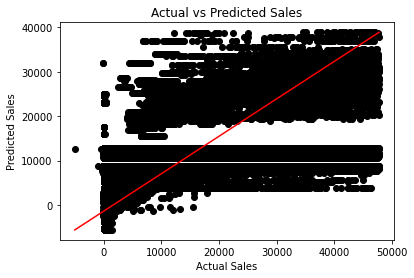

In [42]:
#Plot the results
plt.scatter(y_test2, y_pred1, color = 'black')
x0 = min(y_test2)
x1 = max(y_test2)
y0 = min(y_pred1)
y1 = max(y_pred1)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

### Lasso Regression

In [43]:
#Import necessary modules
from sklearn.linear_model import Lasso

In [44]:
# Establish the parameters to make the grid search
param_grid = {'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
              'max_iter': [500,1000],
              'normalize': [False, True],
              'random_state':[None, 42, 123]
             }

In [45]:
#Print the results with the best parameters by using the grid search
grid_search(Lasso, param_grid, cv = 3)

Based on the Cross Validation, the best parameters were: {'alpha': 0.2, 'max_iter': 500, 'normalize': False, 'random_state': None} with a score of: 0.36838488447298


In [46]:
#Run, fit and predict using Lasso 
lasso= Lasso(alpha = 0.2, max_iter = 500)
lasso.fit(X_train, y_train)
y_pred2 = lasso.predict(X_test)

In [47]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', lasso.score(X_train, y_train))
print('The R-Square of the test data set is:', lasso.score(X_test, y_test))

The R-Square of the train data set is: 0.36850445400735965
The R-Square of the test data set is: 0.36993444952831467


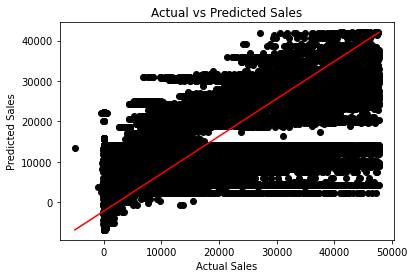

In [48]:
#Plot the results
plt.scatter(y_test, y_pred2, color = 'black')
x0 = min(y_test)
x1 = max(y_test)
y0 = min(y_pred2)
y1 = max(y_pred2)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

In [49]:
#With the Standard Scaler
lasso= Lasso(alpha = 0.2, max_iter = 500)
lasso.fit(X_train2, y_train2)
y_pred2 = lasso.predict(X_test2)

In [50]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', lasso.score(X_train2, y_train2))
print('The R-Square of the test data set is:', lasso.score(X_test2, y_test2))

The R-Square of the train data set is: 0.3245130164904786
The R-Square of the test data set is: 0.3255574575161063


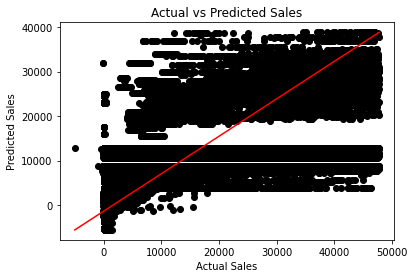

In [51]:
#Plot the results
plt.scatter(y_test2, y_pred2, color = 'black')
x0 = min(y_test2)
x1 = max(y_test2)
y0 = min(y_pred2)
y1 = max(y_pred2)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

### Ridge Regression

In [52]:
#Import necessary libraries
from sklearn.linear_model import Ridge

In [53]:
#Establish the parameters for the grid search
param_grid = {'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
             'normalize': [False, True],
             'random_state': [None, 42, 123],
             'tol': [0.001, 0.01, 0.1, 1]
             }

In [54]:
#Print the best parameters
grid_search(Ridge, param_grid, cv = 3)

Based on the Cross Validation, the best parameters were: {'alpha': 0.4, 'normalize': False, 'random_state': None, 'tol': 0.001} with a score of: 0.3683852637503755


In [55]:
#Run, fit and predict with the parameters above.
ridge = Ridge(alpha = 0.4, normalize = False, tol = 0.001)
ridge.fit(X_train, y_train)
y_pred3 = ridge.predict(X_test)

In [56]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', ridge.score(X_train, y_train))
print('The R-Square of the test data set is:', ridge.score(X_test, y_test))

The R-Square of the train data set is: 0.3685049283676666
The R-Square of the test data set is: 0.3699339540735046


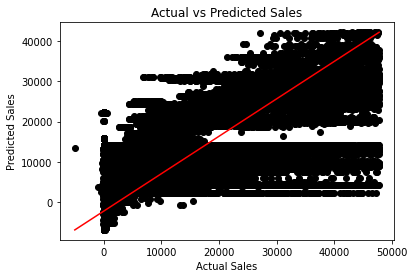

In [57]:
#Plot the results
plt.scatter(y_test, y_pred3, color = 'black')
x0 = min(y_test)
x1 = max(y_test)
y0 = min(y_pred3)
y1 = max(y_pred3)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

In [58]:
#Applying Standard Scaler
ridge = Ridge(alpha = 0.4, normalize = False, tol = 0.001)
ridge.fit(X_train2, y_train2)
y_pred3 = ridge.predict(X_test2)

In [59]:
#Print the score of the test and train set
print('The R-Square of the train data set is:', ridge.score(X_train2, y_train2))
print('The R-Square of the test data set is:', ridge.score(X_test2, y_test2))

The R-Square of the train data set is: 0.32451349881637803
The R-Square of the test data set is: 0.32555637812693683


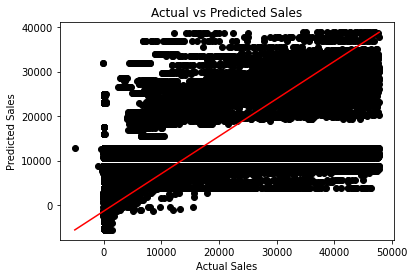

In [60]:
#Plot the results
plt.scatter(y_test2, y_pred3, color = 'black')
x0 = min(y_test2)
x1 = max(y_test2)
y0 = min(y_pred3)
y1 = max(y_pred3)
plt.plot([x0,x1], [y0, y1], color = 'red')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

### Random Forest Regressor

In [61]:
#Import necessary libraries
from sklearn.ensemble import RandomForestRegressor

In [62]:
#Run the test
reg = RandomForestRegressor(max_depth = 20, n_estimators = 20)
reg.fit(X_train, y_train)
y_pred4 = reg.predict(X_test) 

In [63]:
#Calculate the score
print('We got a train score for Random Forest Regressor of:',reg.score(X_train, y_train))
print('We got a test score for Random Forest Regressor of:', reg.score(X_test, y_test))

We got a train score for Random Forest Regressor of: 0.4693299529032221
We got a test score for Random Forest Regressor of: 0.46679690274056374


In [64]:
#With the standarized data 
reg = RandomForestRegressor(max_depth = 20, n_estimators = 20)
reg.fit(X_train2, y_train2)
y_pred4 = reg.predict(X_test2) 

In [65]:
print('We got a train score for Random Forest Regressor of:',reg.score(X_train2, y_train2))
print('We got a test score for Random Forest Regressor of:', reg.score(X_test2, y_test2))

We got a train score for Random Forest Regressor of: 0.4405219506967961
We got a test score for Random Forest Regressor of: 0.43964277156240195


### Gradient Boosting Regression

In [66]:
#Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor

In [67]:
#Run, fit and predict the test
model_gradient = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 20, max_depth = 10)
model_gradient.fit(X_train, y_train)
y_pred5 = model_gradient.predict(X_test)

In [68]:
#Print the results
print('We got a train score for Random Forest Regressor of:',model_gradient.score(X_train, y_train))
print('We got a test score for Random Forest Regressor of:', model_gradient.score(X_test, y_test))

We got a train score for Random Forest Regressor of: 0.42192634637219817
We got a test score for Random Forest Regressor of: 0.42121502154450846


In [69]:
#With the Standarized data
model_gradient = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 20, max_depth = 10)
model_gradient.fit(X_train2, y_train2)
y_pred5 = model_gradient.predict(X_test2)

In [70]:
#Print the results
print('We got a train score for Random Forest Regressor of:',model_gradient.score(X_train2, y_train2))
print('We got a test score for Random Forest Regressor of:', model_gradient.score(X_test2, y_test2))

We got a train score for Random Forest Regressor of: 0.372610944260619
We got a test score for Random Forest Regressor of: 0.37256428263989205


### Decision Tree Regressor

In [71]:
# Decision Tree Regressor 
from sklearn.tree import DecisionTreeRegressor

In [72]:
#Run fit and predict
model_tree = DecisionTreeRegressor(max_depth = None)
model_tree.fit(X_train, y_train)
y_pred6 = model_tree.predict(X_test)

In [73]:
#Print the scores
print('We got a train score for Decision Tree Regressor of:',model_tree.score(X_train, y_train))
print('We got a test score for Decision Tree Regressor of:', model_tree.score(X_test, y_test))

We got a train score for Decision Tree Regressor of: 0.481253005970776
We got a test score for Decision Tree Regressor of: 0.4788926505793193


In [74]:
#With the Standarized data
model_tree = DecisionTreeRegressor(max_depth = None)
model_tree.fit(X_train2, y_train2)
y_pred6 = model_tree.predict(X_test2)

In [75]:
#Print the scores
print('We got a train score for Decision Tree Regressor of:',model_tree.score(X_train2, y_train2))
print('We got a test score for Decision Tree Regressor of:', model_tree.score(X_test2, y_test2))

We got a train score for Decision Tree Regressor of: 0.46436521014343257
We got a test score for Decision Tree Regressor of: 0.46302820381938986


# Conclusions

- Based on the results, Decision trees may be the best regression models we can use to predict the sales of a Walmart store based on the department, size and type of store (variables that looked to have more influence on the weekly sales). 


- For this kind of problems and many others, feature selection plays a very important role before running any regression and have better results. 


- This model is based on the departments that had more correlation with the weekly sales. Though, it does not include all the departments. 